In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

from utils import text_preprocessor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline


from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

## 1. Load Data

Trước tiên, chúng ta cần load dữ liệu lên và xem qua vài dòng trong file dữ liệu

In [2]:
data = pd.read_csv("data/vn_news_223_tdlfr.csv")
data.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


Kiểm tra số dòng, số cột của dữ liệu

In [3]:
data.shape

(223, 3)

Vậy là dữ liệu gồm 223 dòng, 3 cột

## 2. Data understanding

#### Kiểm tra phân bố các class có chênh lệch hay không (label)

In [4]:
data['label'].value_counts()

0    123
1    100
Name: label, dtype: int64

*Trực quan hóa dữ liệu*

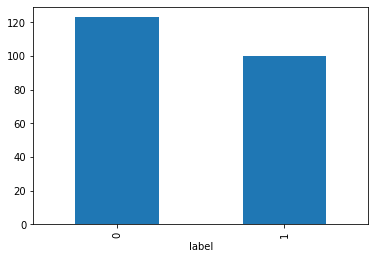

In [5]:
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

Vậy là phân bố dữ liệu của `label` không có lệch lắm. Ta không cần phải thu thập dữ liệu thêm

#### Kiểm tra dữ liệu bị thiếu và dữ liệu bị trùng lắp

In [6]:
# Kiem tra du lieu co bi trung lap
num_row_duplicated = data.duplicated().sum()
num_row_duplicated

1

Vậy là có **1** dòng nào bị trùng lắp. Ta cần bỏ nó đi

In [7]:
data = data.drop_duplicates()
data.shape

(222, 3)

Tiếp theo ta cần kiểm tra và xử lý các giá trị bị thiếu

In [8]:
#Kiểm tra xem có dòng nào bị thiếu không?
data.isna().sum()

text      0
domain    0
label     0
dtype: int64

Vậy là không có dòng nào bị thiếu

#### Các thông tin thống kê của văn bản

- Có bao nhiêu chủ đề cho mỗi tên miền

In [9]:
data.groupby(['domain'])['text'].count()

domain
autoxe.net                  1
baoangiang.com.vn           1
baonuocmy.com               1
binhluan.biz                1
dantri.com.vn              14
doisong.vnexpress.net       2
dulich.vnexpress.net        1
giadinhtiepthi.com          2
giaitri.vnexpress.net       2
haiduong.tintuc.vn          1
https://news.zing.vn        1
kinhdoanh.vnexpress.net     3
laodong.vn                  1
news.zing.vn                6
phapluat.news               3
sohoa.vnexpress.net         1
sorry.vn                    1
suckhoe.vnexpress.net       1
thanhnien.vn                5
thegioitre.vn               2
thethao.tuoitre.vn         10
thoibao.de                  2
thoibao.today               6
tintucqpvn.net              5
tinvn.info                 67
tuoitre.vn                  5
vnexpress.net              73
www.gioitreviet.net         1
www.ipick.vn                2
www.vietgiaitri.com/        1
Name: text, dtype: int64

Trực quan hóa dữ liệu trên

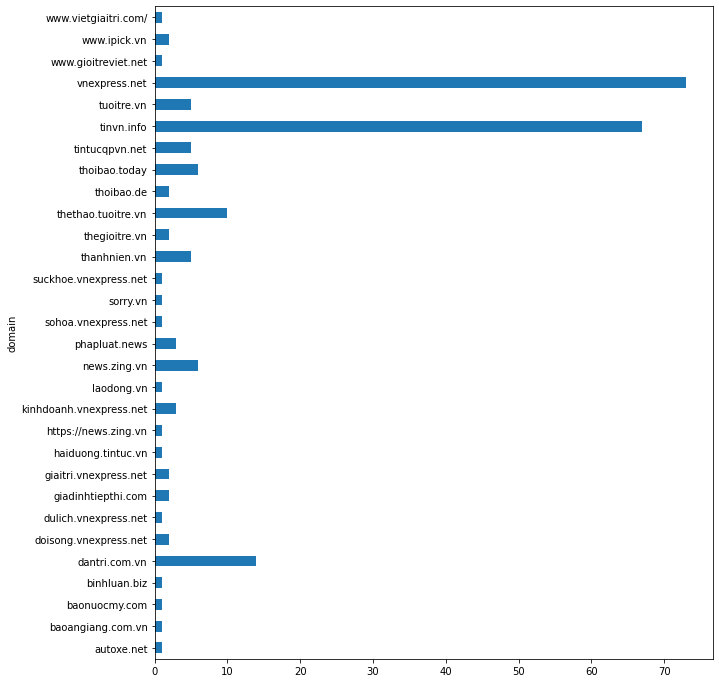

In [10]:
rcParams["figure.figsize"] = 10, 12
data.groupby(['domain'])['text'].count().plot(kind="barh")
plt.show()

Ta thấy rằng đa số dữ liệu đều tập trung ở 2 trang **vnexpress.net** và **tinvn.info**

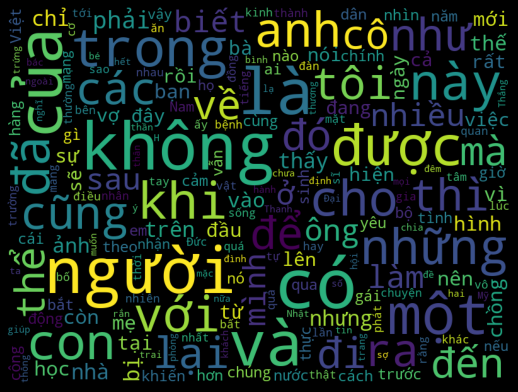

In [11]:
#Đám mây tin giả
fake_data = ' '.join(list(data[data['label']==1]['text']))
fake_data = WordCloud(width= 800, height= 600,
                          max_font_size = 110,
                          collocations = False).generate(fake_data)


plt.figure(figsize=(7,7),facecolor='k')
plt.imshow(fake_data)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

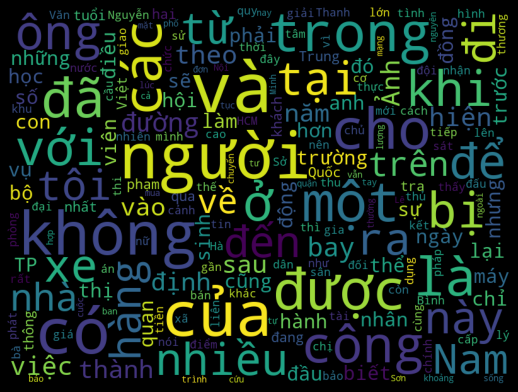

In [12]:
#Đám mây tin thật
real_data = ' '.join(list(data[data['label']==0]['text']))
real_data = WordCloud(width= 800, height= 600,
                          max_font_size = 110,
                          collocations = False).generate(real_data)


plt.figure(figsize=(7,7),facecolor='k')
plt.imshow(real_data)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 3. Train test split

Ta chia tập huấn luyện và tập test theo tỉ lệ 4/5, 1/5

In [13]:
y = data['label']
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Preprocessing

*Tokenize* các từ là thao tác tách các từ có nghĩa ra riêng biệt nhau giúp cho việc học máy tốt hơn.
Thư viện pivy và underthesea hỗ trợ tokenize cho tiếng Việt, nhưng vì thời gian tokenize của underthesea gấp 8 lần pivy, vì vậy chúng ta sẽ dùng pivy.

#### Make pipeline for preprocessing and vectorizing

**Trích chọn thuộc tính trong đoạn văn bản với TF-IDF**
Mô hình Vector Space Model biểu diễn văn bản thành dạng một vector, các phần tử trong vector có thể biểu diễn mức độ quan trọng của một từ (TF-IDF) hoặc dạng có mặt hoặc vằng mặt của một từ trong đoạn văn bản
- `TF(Term Frequency)`: tần suất xuất hiện của một từ trong đoạn văn bản
- `IDF(Inverse Document Frequency)`: tính toán độ quan trọng của mỗi từ
![image.png](http://3.bp.blogspot.com/-u928a3xbrsw/UukmRVX_JzI/AAAAAAAAAKE/wIhuNmdQb7E/s1600/td-idf-graphic.png)

In [16]:
preprocessing_pipeline = make_pipeline(
    FunctionTransformer(text_preprocessor, validate=False),
    TfidfVectorizer(analyzer='word', min_df=0)
)

#### Calculate and preprocess for X_train

In [17]:
processed_X_train = preprocessing_pipeline.fit_transform(X=X_train)
processed_X_train = processed_X_train.toarray()
processed_X_train.shape

(177, 7392)

*Visualize the vectorizing*

In [18]:
count_df = pd.DataFrame(processed_X_train, 
                        columns=preprocessing_pipeline['tfidfvectorizer'].get_feature_names())
count_df.head()

,001,01,012018,03,0412,10,100,1000,10000,10000usd,...,ở_rể,ở_vậi,ủng_hộ,ủy,ủy_ban,ủy_viên,ứng,ứng_dụng,ứng_phó,ứng_viên
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.031056,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.051049,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.048474,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Apply preprocessing for X_test

In [19]:
processed_X_test = preprocessing_pipeline.transform(X=X_test)
processed_X_test = processed_X_test.toarray()
processed_X_test.shape

(45, 7392)

#### Export Vectorizer to file for deploying

In [20]:
pickle_out = open("models/vectorizer.pkl","wb")
pickle.dump(preprocessing_pipeline['tfidfvectorizer'], pickle_out)
pickle_out.close()

## 5. Model

#### 5.1 Multinomial Naive Bayes

In [21]:
# find the Multinomial Naive Bayes model
best_score = 0
best_model = None

for alpha in np.arange(0, 1, 0.1):
    sub_classifier = MultinomialNB(alpha=alpha)
    sub_classifier.fit(processed_X_train, y_train)
    
    y_pred = sub_classifier.predict(processed_X_train)
    
    score = accuracy_score(y_train, y_pred)
    
    if score > best_score:
        best_model = sub_classifier
        best_score = score
    
# create new model with the best alpha
y_pred = best_model.predict(processed_X_test)
accuracy_score(y_test, y_pred)

C:\Users\TheHai\miniconda3\envs\min_ds-env\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


0.8888888888888888

*Export model to file*

In [22]:
pickle_out = open("models/naive-bayes.pkl","wb")
pickle.dump(best_model, pickle_out)
pickle_out.close()

#### 5.2 Support Vector Machine

In [23]:
clf = SVC(kernel='linear',C=1.0)
clf.fit(processed_X_train, y_train)
y_pred = clf.predict(processed_X_test)
accuracy_score(y_test, y_pred)

0.9111111111111111

*Export model to file*

In [24]:
pickle_out = open("models/support-vector-machine.pkl","wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

####  5.3 Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(processed_X_train, y_train)
y_pred = lr.predict(processed_X_test)
accuracy_score(y_test, y_pred)

0.9111111111111111

*Export model to file*

In [26]:
pickle_out = open("models/logistic-regression.pkl","wb")
pickle.dump(lr, pickle_out)
pickle_out.close()

#### 5.4 Random Forest Classifier

In [27]:
rfc = RandomForestClassifier()
rfc.fit(processed_X_train, y_train)
y_pred = rfc.predict(processed_X_test)
accuracy_score(y_test, y_pred)

0.8888888888888888

*Export model to file*

In [28]:
pickle_out = open("models/random-forest.pkl","wb")
pickle.dump(rfc, pickle_out)
pickle_out.close()